In [1]:
!pip -q install tensorflow[keras]


[notice] A new release of pip is available: 23.2.1 -> 24.3.1
[notice] To update, run: pip install --upgrade pip


In [2]:
from sklearn.preprocessing import MinMaxScaler, LabelEncoder
from sklearn.model_selection import train_test_split
from tensorflow.keras import layers
from tensorflow.keras import utils
import tensorflow as tf
import tensorflow.compat.v1 as tf1

import pandas as pd
import numpy as np
import pickle

2024-12-19 08:36:22.000439: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2024-12-19 08:36:22.002410: I external/local_xla/xla/tsl/cuda/cudart_stub.cc:32] Could not find cuda drivers on your machine, GPU will not be used.
2024-12-19 08:36:22.005606: I external/local_xla/xla/tsl/cuda/cudart_stub.cc:32] Could not find cuda drivers on your machine, GPU will not be used.
2024-12-19 08:36:22.014456: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1734597382.029447     407 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1734597382.03

In [3]:
predict_target = "price"

In [4]:
df = pd.read_csv("clean_OMEA_dataset.csv")

In [5]:
scaler = MinMaxScaler()

df[['size', 'width', 'height', 'depth', 'discount_amount','price']] = scaler.fit_transform(df[['size', 'width', 'height', 'depth', 'discount_amount','price']])
df.head()

,name,category,price,old_price,sellable_online,other_colors,short_description,depth,height,width,discounted,width_d,height_d,depth_d,discount_amount,size
0,FREKVENS,Bar furniture,0.027343,265.0,True,No,"Bar table, in/outdoor, 51x51 cm",0.179398,0.140200,0.119332,0,1,1,0,0.0,0.000370
1,NORDVIKEN,Bar furniture,0.103527,995.0,False,No,"Bar table, 140x80 cm",0.179398,0.148784,0.188544,0,1,1,0,0.0,0.000616
2,NORDVIKEN / NORDVIKEN,Bar furniture,0.218326,2095.0,False,No,Bar table and 4 bar stools,0.179398,0.138157,0.123976,0,0,0,0,0.0,0.000000
3,STIG,Bar furniture,0.006888,69.0,True,Yes,"Bar stool with backrest, 74 cm",0.191406,0.141631,0.140811,0,1,1,1,0.0,0.022012
4,NORBERG,Bar furniture,0.023168,225.0,True,No,"Wall-mounted drop-leaf table, ...",0.230469,0.060086,0.174224,0,1,1,1,0.0,0.014008


In [12]:
df_train, df_test = train_test_split(df, shuffle=True, test_size=0.3, random_state=42)

In [14]:
# List to hold all feature inputs
inputs = {}

# Numeric columns
numeric_keys = ['discount_amount', 'size', 'width', 'height', 'depth', 'width_d', 'height_d', 'depth_d', 'price']
numeric_keys.remove(predict_target)
for key in numeric_keys:
    inputs[key] = tf.keras.Input(shape=(1,), name=key, dtype=tf.float32)

# Categorical column for other_colors
other_colors_input = tf.keras.Input(shape=(1,), name='other_colors', dtype='string')
other_colors_encoded = tf.keras.layers.StringLookup(vocabulary=['Yes', 'No'], output_mode='one_hot')(other_colors_input)

# Categorical column for the item categories
category_vocab = ['Bar furniture', 'Beds', 'Bookcases & shelving units',
                  'Cabinets & cupboards', 'Café furniture', 'Chairs',
                  'Chests of drawers & drawer units', "Children's furniture",
                  'Nursery furniture', 'Outdoor furniture', 'Room dividers',
                  'Sideboards, buffets & console tables', 'Sofas & armchairs',
                  'Tables & desks', 'Trolleys', 'TV & media furniture', 'Wardrobes']
category = tf.keras.Input(shape=(1,), name='category', dtype='string')
category_encoded = tf.keras.layers.StringLookup(vocabulary=category_vocab, output_mode='one_hot')(category)

inputs['other_colors'] = other_colors_input
inputs['category'] = category

all_features = tf.keras.layers.concatenate([inputs[key] for key in numeric_keys] + [other_colors_encoded] + [category_encoded])

# Create our pre-processing model
pre_processing_model = tf.keras.Model(inputs=[inputs[key] for key in inputs], outputs=all_features)

2024-12-19 08:38:16.870132: E external/local_xla/xla/stream_executor/cuda/cuda_driver.cc:152] failed call to cuInit: INTERNAL: CUDA error: Failed call to cuInit: UNKNOWN ERROR (303)


In [15]:
def create_model(my_learning_rate, preprocessing_layer):
    model = tf.keras.Sequential([
        preprocessing_layer,
        tf.keras.layers.Dense(20, activation='relu', name='Hidden1'),
        tf.keras.layers.Dense(10, activation='relu', name='Hidden2'),
        tf.keras.layers.Dense(1, name='Output')
    ])

    model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=my_learning_rate),
                  loss='mean_squared_error',
                  metrics=[tf.keras.metrics.MeanSquaredError()])
    return model

In [16]:
# Hyperparameters
learning_rate = 0.01
epochs = 20
batch_size = 2

# Create the model
model = create_model(learning_rate, pre_processing_model)

# Prepare data for training
feature_columns = [col for col in df_train.columns if col not in ['name', 'category', 'short_description', 'sellable_online', 'other_colors', predict_target]]
features = df_train[feature_columns].astype('float32')
features["category"] = df_train["category"].astype("string")
features["other_colors"] = df_train["other_colors"].astype("string")
dict_features = {key: features[[key]] for key in features.keys()}

labels = df_train[[predict_target]]  # Target variable
dict_labels = {key: labels[[key]] for key in labels.keys()}

# Fit the model
history = model.fit(dict_features, dict_labels, epochs=epochs, batch_size=batch_size)

Epoch 1/20
1289/1289 ━━━━━━━━━━━━━━━━━━━━ 2s 871us/step - loss: 0.0194 - mean_squared_error: 0.0194
Epoch 2/20
1289/1289 ━━━━━━━━━━━━━━━━━━━━ 1s 865us/step - loss: 0.0096 - mean_squared_error: 0.0096
Epoch 3/20
1289/1289 ━━━━━━━━━━━━━━━━━━━━ 1s 851us/step - loss: 0.0103 - mean_squared_error: 0.0103
Epoch 4/20
1289/1289 ━━━━━━━━━━━━━━━━━━━━ 1s 858us/step - loss: 0.0098 - mean_squared_error: 0.0098
Epoch 5/20
1289/1289 ━━━━━━━━━━━━━━━━━━━━ 1s 850us/step - loss: 0.0085 - mean_squared_error: 0.0085
Epoch 6/20
1289/1289 ━━━━━━━━━━━━━━━━━━━━ 1s 865us/step - loss: 0.0088 - mean_squared_error: 0.0088
Epoch 7/20
1289/1289 ━━━━━━━━━━━━━━━━━━━━ 1s 871us/step - loss: 0.0073 - mean_squared_error: 0.0073
Epoch 8/20
1289/1289 ━━━━━━━━━━━━━━━━━━━━ 1s 873us/step - loss: 0.0079 - mean_squared_error: 0.0079
Epoch 9/20
1289/1289 ━━━━━━━━━━━━━━━━━━━━ 1s 872us/step - loss: 0.0088 - mean_squared_error: 0.0088
Epoch 10/20
1289/1289 ━━━━━━━━━━━━━━━━━━━━ 1s 851us/step - loss: 0.0082 - mean_squared_error: 0.0082

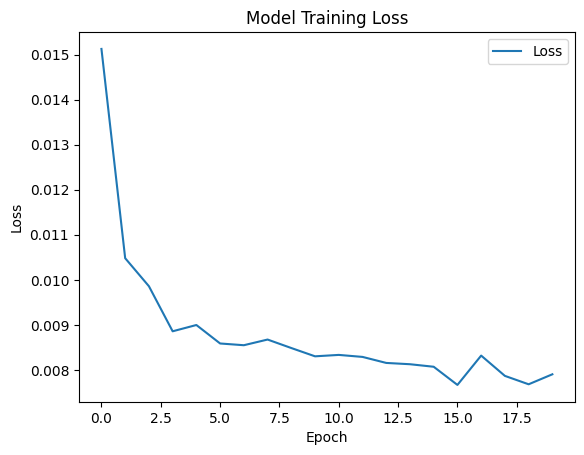

In [17]:
import matplotlib.pyplot as plt

plt.plot(history.history['loss'], label='Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Model Training Loss')
plt.legend()
plt.show()

In [18]:
# Evaluate performance on the test set
test_features = {name:np.array(value) for name, value in df_test.items()}
test_label = np.array(test_features.pop(predict_target)) # isolate the label

print("\n Evaluate the new model against the test set:")
model.evaluate(x = test_features, y = test_label, batch_size=batch_size)


 Evaluate the new model against the test set:
553/553 ━━━━━━━━━━━━━━━━━━━━ 1s 842us/step - loss: 0.0081 - mean_squared_error: 0.0081


[0.007332011125981808, 0.007332011125981808]

In [29]:
# Get all test predictions
prediction = model(test_features)

<tf.Tensor: shape=(1106, 1), dtype=float32, numpy=
array([[ 0.07195662],
       [ 0.07942047],
       [ 0.12164812],
       ...,
       [-0.02760289],
       [ 0.18021566],
       [ 0.12756853]], dtype=float32)>

In [30]:
# Replace the ground truth with the predicted value
prediction_value = prediction.numpy()
predicted_df = input_test_df.copy()
predicted_df[predict_target] = prediction_value

In [31]:
# Unscale and look at the results
predicted_df[['size', 'width', 'height', 'depth', 'discount_amount','price']] = scaler.inverse_transform(predicted_df[['size', 'width', 'height', 'depth', 'discount_amount','price']])
predicted_df['discount_amount'] = predicted_df['old_price'] - predicted_df['price']
predicted_df

,name,category,price,old_price,sellable_online,other_colors,short_description,depth,height,width,discounted,width_d,height_d,depth_d,discount_amount,size
2023,PRÄSTHOLM,Outdoor furniture,692.488329,695.0,True,No,"Bench with backrest, outdoor",52.000000,79.000000,113.000000,0,1,1,1,2.511671,464204.0
2587,LIDHULT,Sofas & armchairs,764.006941,845.0,True,Yes,Cover for 3-seat section,106.320346,77.233216,186.908425,0,0,0,0,80.993059,1.0
3222,EKEDALEN / BERNHARD,Tables & desks,1168.632266,5465.0,True,No,"Table and 6 chairs, 180/240 cm",52.813953,72.610169,76.494990,0,0,0,0,4296.367734,1.0
1263,VEDBO,Chairs,845.362796,1345.0,True,Yes,High-back armchair,85.000000,108.000000,80.000000,0,1,1,1,499.637204,734400.0
781,VITTSJÖ,Bookcases & shelving units,1593.138900,1035.0,True,No,"Storage combination, 300x36x1...",36.000000,175.000000,300.000000,0,1,1,1,-558.138900,1890000.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1231,SKOGSTORP,Chairs,726.008335,795.0,True,No,"Bench, 132 cm",36.000000,45.000000,132.000000,0,1,1,1,68.991665,213840.0
3172,INGATORP / SAKARIAS,Tables & desks,1168.632266,4025.0,True,No,"Table and 4 chairs, 110/155 cm",52.813953,72.610169,76.494990,0,0,0,0,2856.367734,1.0
3410,BESTÅ,TV & media furniture,-261.490879,15.0,True,No,"Supporting leg, 10 cm",37.150376,10.000000,132.285714,0,0,1,0,276.490879,10.0
1283,MELLTORP / MARIUS,Chairs,1729.826423,175.0,True,No,"Table and 2 stools, 75 cm",60.676259,72.000000,75.000000,1,1,1,0,-1554.826423,5400.0


In [26]:
# See where we predict a price below 0
predicted_df[predicted_df["price"]<0]

,name,category,price,old_price,sellable_online,other_colors,short_description,depth,height,width,discounted,width_d,height_d,depth_d,discount_amount,size
1052,EKET,Cabinets & cupboards,-61.076837,125.0,True,Yes,"Wall cabinet with glass door, ...",25.000000,35.000000,35.000000,0,1,1,1,0.0,30625.0
1869,LANGUR,Nursery furniture,-173.783611,50.0,True,No,Padded seat cover for highchair,21.000000,40.000000,22.000000,0,1,1,1,0.0,18480.0
2063,YTTERÖN,Outdoor furniture,-183.916629,99.0,True,No,"Seat/back cushion, outdoor, 9...",68.221154,75.503817,50.000000,0,1,0,0,0.0,50.0
907,EDVALLA,Cabinets & cupboards,-141.936236,25.0,True,No,"Drop handle, 18 mm",11.000000,113.408696,33.000000,0,1,0,1,0.0,363.0
1747,MAMMUT,Children's furniture,-147.978452,29.0,True,No,Children's stool,44.521277,75.857143,35.000000,0,1,0,0,0.0,35.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1598,HELMER,Chests of drawers & drawer units,-278.311993,179.0,True,Yes,"Drawer unit on castors, 28x69 cm",44.000000,69.000000,28.000000,1,1,1,1,4.0,85008.0
420,KALLAX,Bookcases & shelving units,-64.935260,75.0,True,Yes,"Insert with 2 drawers, 33x33 cm",37.000000,33.000000,33.000000,0,1,1,1,0.0,40293.0
1973,STACKHOLMEN,Outdoor furniture,-97.224334,125.0,True,No,"Stool, outdoor, 48x35x43 cm",68.221154,43.000000,35.000000,0,1,1,0,0.0,1505.0
350,ALGOT,Bookcases & shelving units,-46.929476,30.0,True,Yes,"Mesh basket, 38x60x14 cm",60.000000,14.000000,38.000000,1,1,1,1,12.0,31920.0


In [23]:
# Grab one sample and see its discount and new price
original_price = list(predicted_df.to_dict()['old_price'].values())[0]
predicted_new_price = list(predicted_df.to_dict()['price'].values())[0]
predicted_discount = original_price-predicted_new_price

print(f"Original Price: {original_price}\nPredicted Discount: {predicted_discount}\nNew Price: {predicted_new_price}")

Original Price: 695.0
Predicted Discount: 2.511670798063278
New Price: 692.4883292019367


In [32]:
# Save the model and artifacts
model.save("model.keras")

with open("scaler.pkl", "wb") as handle:
    pickle.dump(scaler, handle)

df_train.to_parquet("X_train.parquet")
df_test.to_parquet("X_test.parquet")